In [1]:
import sys
sys.path.append('..')
import selex_dca, utils

import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

import utils
import selex_dca
import selex_distribution, energy_models, tree, data_loading, training, callback, sampling, plotting

from matplotlib import cm
import pickle
import logomaker

/home/scrotti/Aptamer2025py/experiments/../selex_dca.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
experiment_ids = ['Dop8V030', 'Dop8V930', 'Dop8V2430']
round_ids = ["ARN", "R01", "R02N"]

In [3]:
experiment_id_idx = 1
experiment_id = experiment_ids[experiment_id_idx]

In [4]:
model = torch.load(f'saved/{experiment_id}_wd_0.1.pt', weights_only=False, map_location='cpu')

In [5]:
sequences, sequences_unique, counts, log_multinomial_factors = utils.sequences_counts_from_files(experiment_id, round_ids)

Finished round ARN
Finished round R01
Finished round R02N


In [6]:
sequences_unique_all, counts_unique = utils.group_rounds(sequences, sequences_unique, counts)

Merging sequences from all rounds in a single container...
Assigning counts at each round to unique sequences...
	Starting round 0...
	Starting round 1...
	Starting round 2...
Finished


In [7]:
train_valid_idx = torch.load(f'saved/train_test_split/{experiment_id}.pt')
idx_train = train_valid_idx['idx_train']
idx_valid = train_valid_idx['idx_valid']

In [8]:
((sequences_oh, total_reads, log_multinomial_factors), 
 (sequences_valid_oh, total_reads_valid, log_multinomial_factors_valid)) = \
    data_loading.split_train_test(sequences_unique_all, counts_unique, idx_train, idx_valid)

In [9]:
sequences_unique_valid_oh = utils.one_hot(sequences_unique_all[idx_valid])

In [10]:
sequences_oh = [utils.one_hot(s) for s in sequences]
total_reads = torch.tensor([len(s) for s in sequences])

In [48]:
model_indep = torch.load(f'saved/{experiment_id}_indep_sites.pt', weights_only=False, map_location='cpu')

In [49]:
def log_likelihood_indep_sites(model_indep, sequences_oh, total_reads, log_multinomial_factors):
    models_t = [energy_models.IndepSites(model_indep.round_zero.h + t * model_indep.selection.modes[0].h) for t in range(model_indep.get_n_rounds())]
    log_likelihood_normaliz = (total_reads + log_multinomial_factors).sum().item()
    
    log_likelihood = 0.0
    for t in range(model_indep.get_n_rounds()):
        Lt = models_t[t].log_prob(sequences_oh[t]).mean()
        log_likelihood += (log_multinomial_factors[t] + total_reads[t] * Lt).item()
    
    return log_likelihood / log_likelihood_normaliz

In [50]:
nll_indep = - log_likelihood_indep_sites(model_indep, sequences_valid_oh, total_reads_valid, log_multinomial_factors_valid)
nll_indep

3.493932290583988

In [51]:
n_chains = 10**3
n_sweeps = 1
step = 1e-4

In [52]:
def estimate_nll_potts(sequences_oh, model, total_reads, log_multinomial_factors, n_chains, n_sweeps, step):
    batches = sequences_oh
    nll_potts = - training.estimate_log_likelihood_AIS(model, batches, total_reads, log_multinomial_factors, n_chains, n_sweeps, step)
    return nll_potts

In [53]:
weight_decays = [0.0, 1e-2, 1e-1, 1e0]

models_potts = []
for weight_decay in weight_decays:
    model = torch.load(f'saved/{experiment_id}_wd_{weight_decay}.pt', weights_only=False, map_location='cpu')
    models_potts.append(model)

In [54]:
nll_potts = []

for (i, model) in enumerate(models_potts):
    print(f'Starting model {i+1}/{len(models_potts)}')
    nll = estimate_nll_potts(sequences_valid_oh, model, total_reads_valid, log_multinomial_factors_valid, n_chains, n_sweeps, step)
    nll_potts.append(nll)

nll_potts

Starting model 1/4


  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

Starting model 2/4


  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

Starting model 3/4


  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

Starting model 4/4


  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

[3.494238885655289, 3.494874872677005, 3.498474599062487, 3.508838552276916]

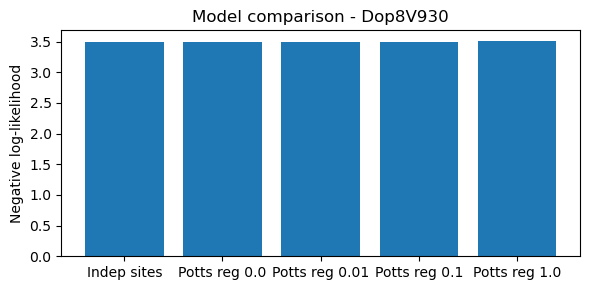

In [55]:
fig, ax = plt.subplots(figsize=(6,3))
ticks = ['Indep sites'] + [f'Potts reg {wd}' for wd in weight_decays]
nlls = [nll_indep] + nll_potts
ax.bar(ticks, nlls)
ax.set_ylabel('Negative log-likelihood')
ax.set_title(f'Model comparison - {experiment_id}')
plt.tight_layout()

In [ ]:
# n_samples = 20
# steps = torch.logspace(-1, -5, 5)
# nlls = []

# for (i, step) in enumerate(steps):
#     print(f'stepsize {step.item():0.3e}, {i+1}/{len(steps)}')
#     nlls_step = []
#     for s in range(n_samples):
#         print(f'\t sample {s+1}/{n_samples}')
#         nll_potts = estimate_nll_potts(sequences_oh, model, total_reads, log_multinomial_factors, n_chains, n_sweeps, step)
#         nlls_step.append(nll_potts)
#     nlls.append(nlls_step)

In [ ]:
# import matplotlib

# cmap=matplotlib.cm.viridis
# colors = [cmap(x) for x in np.flip(np.linspace(0, 1, len(steps)))]

# fig, ax = plt.subplots()
# for (i, step) in reversed(list(enumerate(steps))):
#     ax.plot(nlls[i], label=f'step size {step.item():0.3e}', color=colors[i])
#     ax.axhline(torch.tensor(nlls[i]).mean(), color=colors[i])
# ax.legend()
# ax.set_xlabel('sample')
# ax.set_ylabel('NLL')
# ax.set_yscale('log');

In [ ]:
# means = [torch.tensor(nlls[i]).mean().item() for i in range(len(steps))]
# stds = [(torch.tensor(nlls[i]).std() / torch.sqrt(torch.tensor([len(nlls[i])]))).item() for i in range(len(steps))]

# fig, ax = plt.subplots()
# ax.errorbar(steps, means, yerr=stds, fmt='o', markersize=5, ecolor='black')
# ax.set_xscale('log')
# ax.set_xlabel('beta step AIS')
# ax.set_ylabel('estimated NLL')
# ax.set_title(f'NLL estimate over {n_samples} samples');

In [358]:
# filepath = f'/home/scrotti/Aptamer2025py/experiments/saved/pseudocount/indep_sites/{experiment_id}_0.00000000.pkl'
# with open(filepath, 'rb') as f:
#     params = pickle.load(f)[2]

# tr = tree.Tree()
# tr.add_node(-1, name = "R01")
# tr.add_node(0, name = "R02N")

# selected_modes = torch.BoolTensor(
#     [[1], [1]]
# )

# Ns0 = energy_models.IndepSites(params['bias_Ns0'])

# ps = selex_distribution.MultiModeDistribution(energy_models.IndepSites(params['bias_ps']), normalized=False)
# model = selex_distribution.MultiRoundDistribution(Ns0, ps, tr, selected_modes)

# torch.save(model, f'saved/{experiment_id}_indep_sites.pt')

## Looking around wildtype

In [56]:
model = torch.load(f'saved/{experiment_id}_wd_0.01.pt', weights_only=False, map_location='cpu')

In [57]:
with open('./saved/wildtypes_sites.pkl', 'rb') as f:
    wts = pickle.load(f)

wt = wts[experiment_id_idx]
wt_oh = utils.one_hot(wt)
L = 45
q = 4

In [58]:
def hamming(x, y):
    L = x.size(-1)
    return (x != y).sum(dim=(-1))

In [59]:
def sequences_at_distance_1(wt):
    seq = []
    for i in range(L):
        delta = torch.zeros(L)
        # use itertools.product here to generalize to distance d
        for a in range(1, q):
            delta[i] = a
            s = torch.fmod(delta+wt, q)
            seq.append(s)
    neigs = torch.stack(seq).to(dtype=torch.int)
    assert torch.all(hamming(wt, neigs) == 1)
    return neigs

def sequences_at_distance_2(wt):
    seq = []
    for i in range(L):
        for j in range(L):
            if j != i:
                delta = torch.zeros(L)
                for a in range(1, q):
                    delta[i] = a
                    for b in range(1, q):
                        delta[j] = b
                        s = torch.fmod(delta+wt, q)
                        seq.append(s)
    neigs = torch.stack(seq).to(dtype=torch.int)
    assert torch.all(hamming(wt, neigs) == 2)
    return neigs

def sequences_at_distance_3(wt):
    seq = []
    for i in range(L):
        for j in range(L):
            for k in range(L):
                if j != i and j != k and i != k:
                    delta = torch.zeros(L)
                    for a in range(1, q):
                        delta[i] = a
                        for b in range(1, q):
                            delta[j] = b
                            for c in range(1, q):
                                delta[k] = c
                                s = torch.fmod(delta+wt, q)
                                seq.append(s)
    neigs = torch.stack(seq).to(dtype=torch.int)
    assert torch.all(hamming(wt, neigs) == 3)
    return neigs

In [60]:
def plot_hist(model, wt, neigs, **kwargs):
    neighbors_oh = utils.one_hot(neigs)
    logps_neigs = - model.selection_energy_at_round(neighbors_oh, 1).detach()
    logps_wt = - model.selection_energy_at_round(wt_oh, 1).detach()
    fig, ax = plt.subplots(**kwargs)
    ax.hist(logps_neigs, bins=100, density=True)
    ax.axvline(x=logps_wt.item(), color='red', label="wildtype")
    ax.set_xlabel('logps'); ax.set_ylabel('frequency')
    ax.legend()
    return logps_neigs, logps_wt, fig, ax

In [61]:
def best_mutations(model, wt, neigs):
    neighbors_oh = utils.one_hot(neigs)
    logps_neigs = - model.selection_energy_at_round(neighbors_oh, 1).detach()
    logps_wt = - model.selection_energy_at_round(wt_oh, 1).detach()
    idx_best = logps_neigs >= logps_wt
    logps_best = (logps_neigs - logps_wt)[idx_best]
    perm = torch.argsort(logps_best)
    return torch.argmax(neighbors_oh[idx_best], dim=-1), perm, logps_best

In [62]:
neighbors_1 = sequences_at_distance_1(wt)
neighbors_2 = sequences_at_distance_2(wt)
neighbors_3 = sequences_at_distance_3(wt)

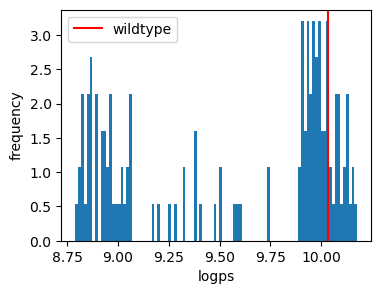

In [63]:
plot_hist(model, wt, neighbors_1, figsize=(4,3))
ax.set_title('Neighbors at distance 1 - potts');

In [64]:
best_1_mutations_potts, perm_1_potts, logps_best_1_potts = best_mutations(model, wt, neighbors_1)

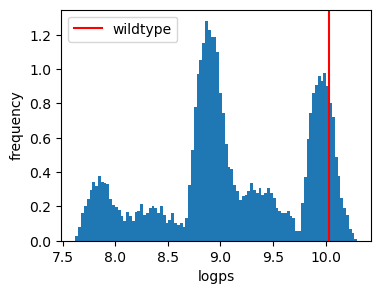

In [65]:
plot_hist(model, wt, neighbors_2, figsize=(4,3))
ax.set_title('Neighbors at distance 2 - potts');

In [66]:
best_2_mutations_potts, perm_2_potts, logps_best_2_potts = best_mutations(model, wt, neighbors_2)

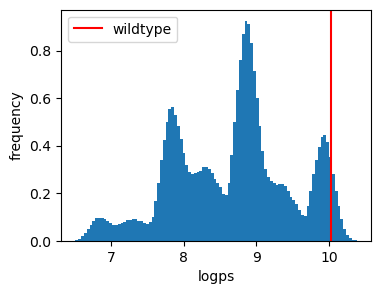

In [67]:
plot_hist(model, wt, neighbors_3, figsize=(4,3))
ax.set_title('Neighbors at distance 3 - potts');

In [68]:
best_3_mutations_potts, perm_3_potts, logps_best_3_potts = best_mutations(model, wt, neighbors_3)

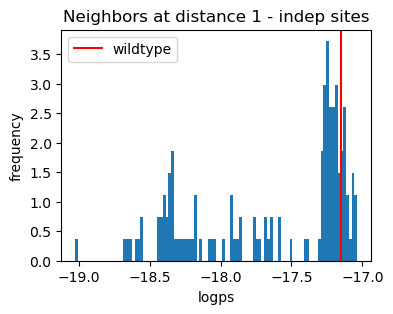

In [69]:
logps_neigs_1_indep, logps_wt_1_indep, fig, ax = plot_hist(model_indep, wt, neighbors_1, figsize=(4,3))
ax.set_title('Neighbors at distance 1 - indep sites');

In [70]:
best_1_mutations_indep, perm_1_indep, logps_best_1_indep = best_mutations(model_indep, wt, neighbors_1)

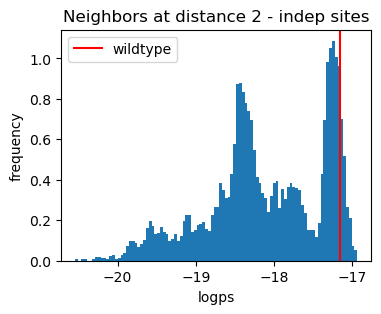

In [71]:
logps_neigs_1_indep, logps_wt_1_indep, fig, ax = plot_hist(model_indep, wt, neighbors_2, figsize=(4,3))
ax.set_title('Neighbors at distance 2 - indep sites');

In [72]:
best_2_mutations_indep, perm_2_indep, logps_best_2_indep = best_mutations(model_indep, wt, neighbors_2)

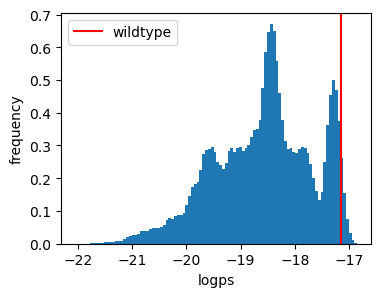

In [73]:
plot_hist(model_indep, wt, neighbors_3, figsize=(4,3))
ax.set_title('Neighbors at distance 3 - indep sites');

In [74]:
best_3_mutations_indep, perm_3_indep, logps_best_3_indep = best_mutations(model_indep, wt, neighbors_3)

### Compare best mutations

In [75]:
mutation_idx = [(best_1_mutations_indep[i] != wt).nonzero().item() for i in range(best_1_mutations_indep.size(0))]
wt_letters = [utils.TOKENS_DNA[wt[idx].item()] for (i, idx) in enumerate(mutation_idx)]
mutation_letters = [utils.TOKENS_DNA[best_1_mutations_indep[i][idx].item()] for (i, idx) in enumerate(mutation_idx)]
mutation_idx_unique_1_indep = torch.unique(torch.tensor(mutation_idx))
print('1 SITE - INDEP SITES')
mutations_1_indep = list(zip(mutation_idx, wt_letters, mutation_letters))
mutations_1_indep

1 SITE - INDEP SITES


[(22, 'T', 'C'),
 (23, 'T', 'A'),
 (23, 'T', 'C'),
 (24, 'T', 'A'),
 (24, 'T', 'G'),
 (25, 'C', 'G'),
 (25, 'C', 'T'),
 (25, 'C', 'A'),
 (26, 'C', 'G'),
 (26, 'C', 'A'),
 (33, 'G', 'T'),
 (33, 'G', 'A'),
 (33, 'G', 'C'),
 (34, 'C', 'T'),
 (35, 'C', 'T'),
 (38, 'G', 'A'),
 (38, 'G', 'C'),
 (39, 'C', 'G'),
 (39, 'C', 'T'),
 (39, 'C', 'A'),
 (44, 'G', 'A'),
 (44, 'G', 'C')]

In [76]:
mutation_idx = [(best_1_mutations_potts[i] != wt).nonzero().item() for i in range(best_1_mutations_potts.size(0))]
wt_letters = [utils.TOKENS_DNA[wt[idx].item()] for (i, idx) in enumerate(mutation_idx)]
mutation_letters = [utils.TOKENS_DNA[best_1_mutations_potts[i][idx].item()] for (i, idx) in enumerate(mutation_idx)]
print('1 SITE - POTTS')
mutations_1_potts = list(zip(mutation_idx, wt_letters, mutation_letters))
mutations_1_potts

1 SITE - POTTS


[(22, 'T', 'C'),
 (23, 'T', 'A'),
 (23, 'T', 'C'),
 (24, 'T', 'A'),
 (24, 'T', 'G'),
 (25, 'C', 'G'),
 (25, 'C', 'T'),
 (25, 'C', 'A'),
 (26, 'C', 'A'),
 (32, 'A', 'T'),
 (33, 'G', 'T'),
 (33, 'G', 'A'),
 (33, 'G', 'C'),
 (34, 'C', 'T'),
 (35, 'C', 'T'),
 (38, 'G', 'T'),
 (38, 'G', 'A'),
 (38, 'G', 'C'),
 (39, 'C', 'G'),
 (39, 'C', 'T'),
 (39, 'C', 'A'),
 (42, 'C', 'T'),
 (44, 'G', 'T'),
 (44, 'G', 'A'),
 (44, 'G', 'C')]

In [77]:
mutation_idx = [tuple((best_2_mutations_indep[i] != wt).nonzero().squeeze().tolist()) for i in range(best_2_mutations_indep.size(0))]
wt_letters = [tuple([utils.TOKENS_DNA[wt[idx_]] for idx_ in idx]) for (i, idx) in enumerate(mutation_idx)]
mutation_letters = [[utils.TOKENS_DNA[best_2_mutations_indep[i][idx_].item()] for idx_ in idx] for (i, idx) in enumerate(mutation_idx)]
print('2 SITE - INDEP SITES')
mutations_2_indep = list(zip(mutation_idx, wt_letters, mutation_letters))

2 SITE - INDEP SITES


In [78]:
mutation_idx = [tuple((best_2_mutations_potts[i] != wt).nonzero().squeeze().tolist()) for i in range(best_2_mutations_potts.size(0))]
wt_letters = [tuple([utils.TOKENS_DNA[wt[idx_]] for idx_ in idx]) for (i, idx) in enumerate(mutation_idx)]
mutation_letters = [[utils.TOKENS_DNA[best_2_mutations_potts[i][idx_].item()] for idx_ in idx] for (i, idx) in enumerate(mutation_idx)]
print('2 SITE - POTTS')
mutations_2_potts = list(zip(mutation_idx, wt_letters, mutation_letters))
len(mutations_2_potts)

2 SITE - POTTS


1496

In [79]:
double_good_mutations_potts = []

for m in mutations_2_potts:
    i, j = m[0]
    if (i in mutation_idx_unique_1_indep) and (j in mutation_idx_unique_1_indep):
        double_good_mutations_potts.append(m)
len(double_good_mutations_potts)

752

In [80]:
double_good_mutations_indep = []

for m in mutations_2_indep:
    i, j = m[0]
    if (i in mutation_idx_unique_1_indep) and (j in mutation_idx_unique_1_indep):
        double_good_mutations_indep.append(m)
len(double_good_mutations_indep)

660

In [81]:
torch.all(torch.tensor([m in mutations_2_indep for m in mutations_2_potts]))

tensor(False)

In [82]:
mutation_idx = [tuple((best_3_mutations_indep[i] != wt).nonzero().squeeze().tolist()) for i in range(best_3_mutations_indep.size(0))]
wt_letters = [tuple([utils.TOKENS_DNA[wt[idx_]] for idx_ in idx]) for (i, idx) in enumerate(mutation_idx)]
mutation_letters = [[utils.TOKENS_DNA[best_3_mutations_indep[i][idx_].item()] for idx_ in idx] for (i, idx) in enumerate(mutation_idx)]
print('3 SITE - INDEP SITES')
mutations_3_indep = list(zip(mutation_idx, wt_letters, mutation_letters))
len(mutations_3_indep)

3 SITE - INDEP SITES


60834

In [83]:
mutation_idx = [tuple((best_3_mutations_potts[i] != wt).nonzero().squeeze().tolist()) for i in range(best_3_mutations_potts.size(0))]
wt_letters = [tuple([utils.TOKENS_DNA[wt[idx_]] for idx_ in idx]) for (i, idx) in enumerate(mutation_idx)]
mutation_letters = [[utils.TOKENS_DNA[best_3_mutations_potts[i][idx_].item()] for idx_ in idx] for (i, idx) in enumerate(mutation_idx)]
print('3 SITE - POTTS')
mutations_3_potts = list(zip(mutation_idx, wt_letters, mutation_letters))
len(mutations_3_potts)

3 SITE - POTTS


79002

## NLL at distances

In [84]:
hamming_all = hamming(wt, sequences_unique_all)
# idx_valid_distances = [(hamming_valid == 1).nonzero(), (hamming_valid == 2).nonzero()]
idx_valid_bool = torch.zeros(len(sequences_unique_all), dtype=bool)
idx_valid_bool[idx_valid] = 1
idx_valid_1 = ((hamming_all == 1) * idx_valid_bool).nonzero().squeeze()
idx_valid_2 = ((hamming_all == 2) * idx_valid_bool).nonzero().squeeze()
idx_valid_3 = ((hamming_all == 3) * idx_valid_bool).nonzero().squeeze()
# neighbors_valid_oh_1 = utils.one_hot(sequences_unique_all[idx_valid_1])
# neighbors_valid_oh_2 = utils.one_hot(sequences_unique_all[idx_valid_2])
# neighbors_valid_oh_3 = utils.one_hot(sequences_unique_all[idx_valid_3])

In [85]:
len(idx_valid_1), len(idx_valid_2), len(idx_valid_3)

(8, 2, 7)

In [97]:
sequences_valid_oh_1, total_reads_valid_1, log_multinomial_factors_valid_1 = utils.subsample_sequences(sequences_unique_all, counts_unique, idx_valid_1)
sequences_valid_oh_2, total_reads_valid_2, log_multinomial_factors_valid_2 = utils.subsample_sequences(sequences_unique_all, counts_unique, idx_valid_2)
sequences_valid_oh_3, total_reads_valid_3, log_multinomial_factors_valid_3 = utils.subsample_sequences(sequences_unique_all, counts_unique, idx_valid_3)

In [98]:
nll_indep_1 = - log_likelihood_indep_sites(model_indep, sequences_valid_oh_1, total_reads_valid_1, log_multinomial_factors_valid_1)
nll_indep_1

4.065507143371701

In [99]:
nll_indep_2 = - log_likelihood_indep_sites(model_indep, sequences_valid_oh_2, total_reads_valid_2, log_multinomial_factors_valid_2)
nll_indep_2

10.283495068595197

In [100]:
nll_indep_3 = - log_likelihood_indep_sites(model_indep, sequences_valid_oh_3, total_reads_valid_3, log_multinomial_factors_valid_3)
nll_indep_3

nan

In [101]:
n_chains = 10**3
n_sweeps = 1
step = 1e-4

In [102]:
def estimate_nll_potts(sequences_oh, model, total_reads, log_multinomial_factors, n_chains, n_sweeps, step):
    batches = sequences_oh
    nll_potts = - training.estimate_log_likelihood_AIS(model, batches, total_reads, log_multinomial_factors, n_chains, n_sweeps, step)
    return nll_potts

In [103]:
weight_decays = [0.0, 1e-2, 1e-1, 1e0]

models_potts = []
for weight_decay in weight_decays:
    model = torch.load(f'saved/{experiment_id}_wd_{weight_decay}.pt', weights_only=False, map_location='cpu')
    models_potts.append(model)

In [104]:
nll_potts_1 = []

for (i, model) in enumerate(models_potts):
    print(f'Starting model {i+1}/{len(models_potts)}')
    nll = estimate_nll_potts(sequences_valid_oh_1, model, total_reads_valid_1, log_multinomial_factors_valid_1, n_chains, n_sweeps, step)
    nll_potts_1.append(nll)

nll_potts_1

Starting model 1/4


  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

Starting model 2/4


  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

Starting model 3/4


  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

Starting model 4/4


  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

[4.0493691634483815, 4.086702595774296, 4.18517914304989, 4.377724057598495]

In [105]:
nll_potts_2 = []

for (i, model) in enumerate(models_potts):
    print(f'Starting model {i+1}/{len(models_potts)}')
    nll = estimate_nll_potts(sequences_valid_oh_2, model, total_reads_valid_2, log_multinomial_factors_valid_2, n_chains, n_sweeps, step)
    nll_potts_2.append(nll)

nll_potts_2

Starting model 1/4


  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

Starting model 2/4


  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

Starting model 3/4


  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

Starting model 4/4


  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

[10.254979180606265,
 10.251136042337105,
 10.660806567308962,
 10.941095428514227]

In [106]:
nll_potts_3 = []

for (i, model) in enumerate(models_potts):
    print(f'Starting model {i+1}/{len(models_potts)}')
    nll = estimate_nll_potts(sequences_valid_oh_3, model, total_reads_valid_3, log_multinomial_factors_valid_3, n_chains, n_sweeps, step)
    nll_potts_3.append(nll)

nll_potts_3

Starting model 1/4


  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

Starting model 2/4


  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

Starting model 3/4


  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

Starting model 4/4


  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

[nan, nan, nan, nan]

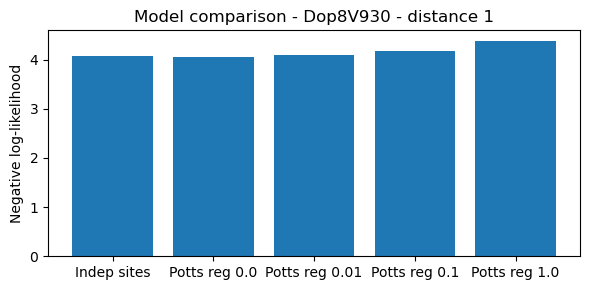

In [107]:
fig, ax = plt.subplots(figsize=(6,3))
ticks = ['Indep sites'] + [f'Potts reg {wd}' for wd in weight_decays]
nlls_1 = [nll_indep_1] + nll_potts_1
ax.bar(ticks, nlls_1)
ax.set_ylabel('Negative log-likelihood')
ax.set_title(f'Model comparison - {experiment_id} - distance 1')
plt.tight_layout()

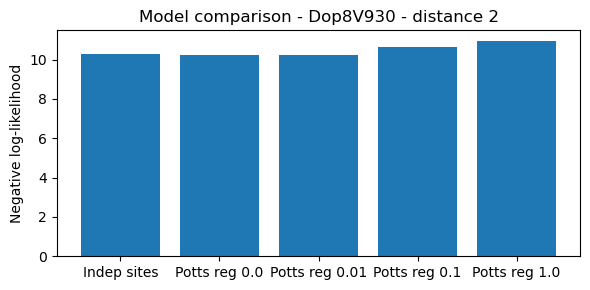

In [108]:
fig, ax = plt.subplots(figsize=(6,3))
ticks = ['Indep sites'] + [f'Potts reg {wd}' for wd in weight_decays]
nlls_2 = [nll_indep_2] + nll_potts_2
ax.bar(ticks, nlls_2)
ax.set_ylabel('Negative log-likelihood')
ax.set_title(f'Model comparison - {experiment_id} - distance 2')
plt.tight_layout()

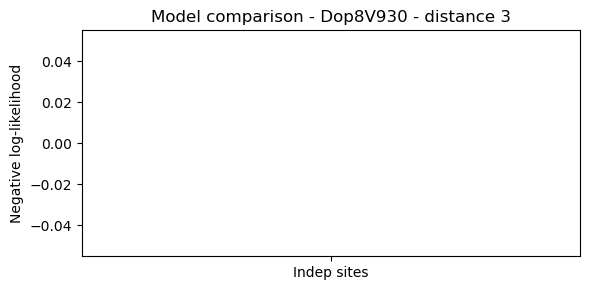

In [109]:
fig, ax = plt.subplots(figsize=(6,3))
ticks = ['Indep sites'] + [f'Potts reg {wd}' for wd in weight_decays]
nlls_3 = [nll_indep_3] + nll_potts_3
ax.bar(ticks, nlls_3)
ax.set_ylabel('Negative log-likelihood')
ax.set_title(f'Model comparison - {experiment_id} - distance 3')
plt.tight_layout()

In [110]:
nlls = torch.stack([torch.tensor(nlls_1), torch.tensor(nlls_2), torch.tensor(nlls_3)])

Text(0, 0.5, 'difference in NLL wrt indep sites')

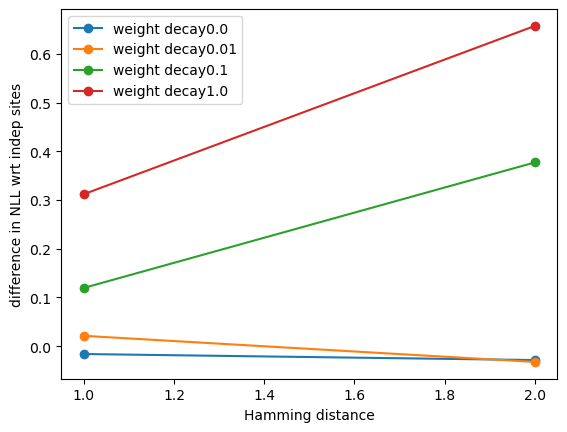

In [111]:
delta_nlls = nlls[:,1:] - nlls[:,0:1]
distances = [1,2,3]

fig, ax = plt.subplots()
ax.plot(distances, delta_nlls, marker='o', label=['weight decay' + str(w) for w in weight_decays])
ax.legend()
ax.set_xlabel('Hamming distance')
ax.set_ylabel('difference in NLL wrt indep sites')